In [1]:
# Quick notebook to train and save a model (either FGN or classic)

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
!gpustat

countdown  Fri Aug  9 16:54:28 2019
[0] GeForce GTX 1080 | 41'C,   0 % |   565 /  8119 MB | felix(553M)
[1] GeForce GTX 1080 | 41'C,   0 % |  2449 /  8118 MB | felix(1613M)


In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# manualy set cuda device
torch.cuda.set_device(0)

CUDA Available:  True
Using device: cuda


In [7]:
# # random seeds
# torch.manual_seed(999)
# np.random.seed(999)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [8]:
# MNIST dataset and dataloader declaration
# transforms does both the conversion from 0-255 to 0-1
# and normalizes by the precomputed mean and std

batch_size = 192

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=True, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../MNIST-dataset', train=False, download=False, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))
            ])), 
        batch_size=batch_size, shuffle=True)

Shape: torch.Size([60000, 28, 28])
type: <type 'numpy.ndarray'>
shape: torch.Size([28, 28])
Label: 5
type: <class 'torch.Tensor'>


<IPython.core.display.Javascript object>


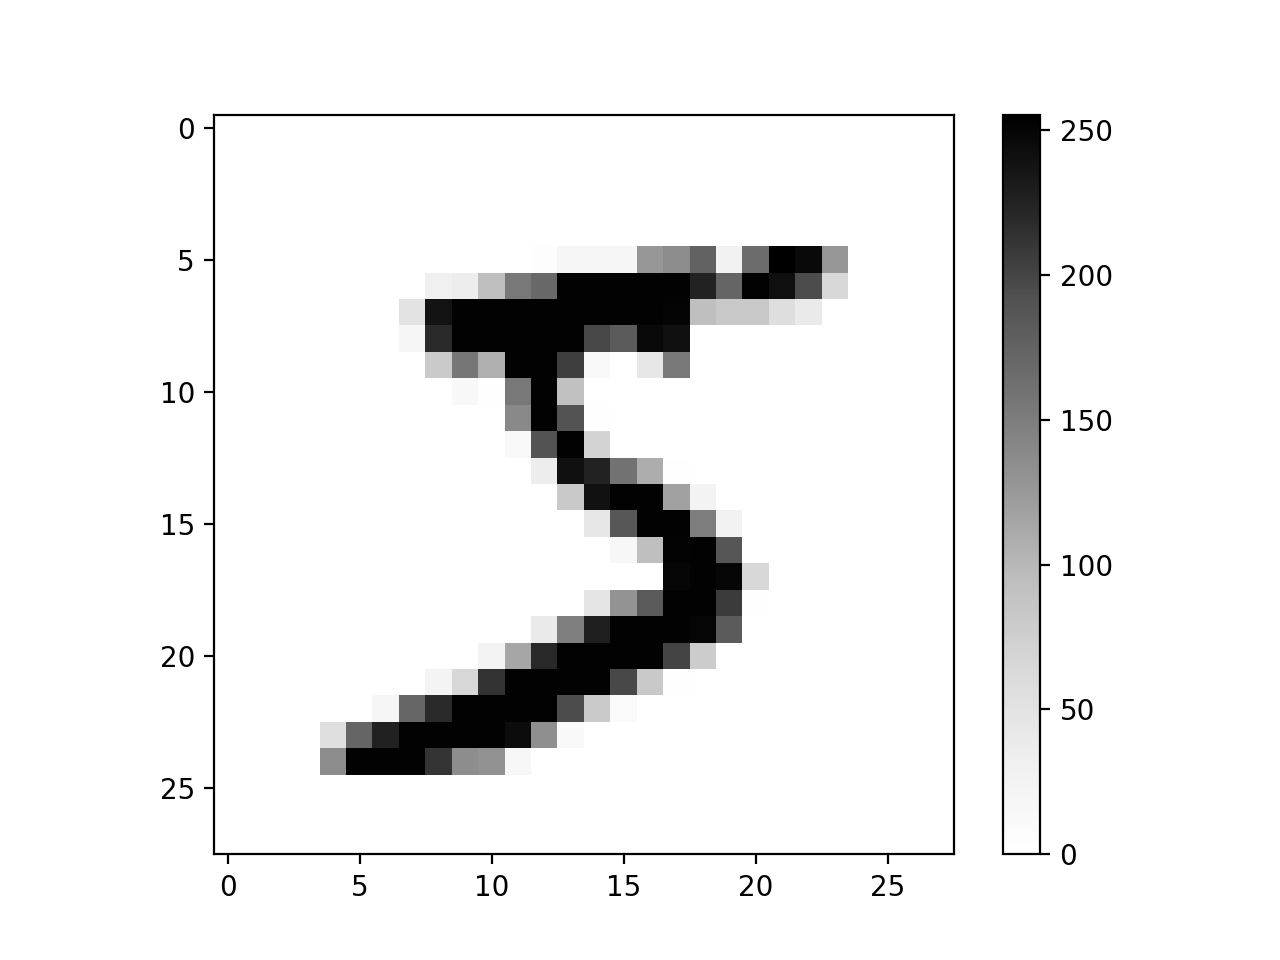

In [9]:
# show an example
print("Shape:", mnist_train_loader.dataset.data.shape)
x = mnist_train_loader.dataset.data[0]
print("type:", type(x.numpy()))
print("shape:", x.shape)
# print("sample:", x.numpy())

y = mnist_train_loader.dataset.targets[0]
print("Label:",y.numpy())
print("type:", type(y))

plt.imshow(x, cmap=plt.cm.get_cmap('Greys'))
plt.colorbar()
plt.show()

In [10]:
# # loss functions for the classic net
# lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
# print(lmbda_l2)
# cross_ent_loss = fgnh.def_classical_cross_ent_loss(lmbda_l2)


### Loss Functions for the FGN
# importances of the constraints
lmbda_l2 = (4.0*0.1/len(mnist_train_loader.dataset))
lmbda_sigs = 200.0*lmbda_l2
# sig_params = sum(p.numel() for n,p in fgn_model.named_parameters() if 'sigs' in n)
# lmbda_sigs = (1.0/sig_params)

# lmbda_l2 = 0.0
# lmbda_sigs = 0.0
print("lambda for l2 loss", lmbda_l2)
print("lambda for sigs^2 loss", lmbda_sigs)

cross_ent_loss = fgnl.def_fgn_cross_ent_loss(lmbda_l2, lmbda_sigs)

lambda for l2 loss 6.66666666667e-06
lambda for sigs^2 loss 0.00133333333333


In [11]:
# shared network parameters
hidden_l_nums = [32,32]
drop_p = 5.0/32.0

In [12]:
# classic model init
# model = fgnl.Feedforward_Classic_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums, drop_p=drop_p).to(device)

print("hidden layers:", hidden_l_nums)
print("drop prob:", drop_p)
# fgn specific params
ordinal = float(1)
print("ordinal:", ordinal)
noisy_centers = False
print("noisy centers:", noisy_centers)
random_eval = False
print("Random Eval", random_eval)

#fgn model init
model = fgnl.Feedforward_FGN_net(in_feats=28*28, out_feats=10, hidden_l_nums=hidden_l_nums,
                                     drop_p=drop_p, noisy_centers=noisy_centers, random_eval=random_eval).to(device)

hidden layers: [32, 32]
drop prob: 0.2
ordinal: 1.0
noisy centers: False
Random Eval False


In [13]:
# define model params to optimize
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()),momentum=0.5)

In [14]:
epochs = 5

In [15]:
# train the network for N epochs
train_res = fgnh.train(model, mnist_train_loader, 
                             cross_ent_loss, optimizer, epochs, save_hist=2, verbose=True, 
                             pred_func=fgnh.cross_ent_pred_accuracy, test_loader=mnist_test_loader)

Epoch 0 Train set - Average loss: 1.2728, Accuracy: 45781/60000 (76%)
Test set - Average loss: 0.7035, Accuracy: 8856/10000 (89%)
Epoch 1 Train set - Average loss: 0.7132, Accuracy: 51699/60000 (86%)
Test set - Average loss: 0.6246, Accuracy: 8846/10000 (88%)
Epoch 2 Train set - Average loss: 0.5627, Accuracy: 52685/60000 (88%)
Test set - Average loss: 0.4304, Accuracy: 9201/10000 (92%)
Epoch 3 Train set - Average loss: 0.4887, Accuracy: 53250/60000 (89%)
Test set - Average loss: 0.5094, Accuracy: 8789/10000 (88%)
Epoch 4 Train set - Average loss: 0.4353, Accuracy: 53735/60000 (90%)
Test set - Average loss: 0.4289, Accuracy: 9075/10000 (91%)


In [16]:
# test the statibility of the model (these numbers should be same as final lines above)
model.set_random_eval(False)
test_res = fgnh.test(model, mnist_train_loader, cross_ent_loss,
                               pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.4239, Accuracy: 54325/60000 (91%)


In [17]:
# switch to random eval
model.set_random_eval(True)
test_res = fgnh.test(model, mnist_train_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

test_res = fgnh.test(model, mnist_test_loader,
                        cross_ent_loss, pred_func=fgnh.cross_ent_pred_accuracy, verbose=True)

Test set - Average loss: 0.4239, Accuracy: 54313/60000 (91%)
Test set - Average loss: 0.4283, Accuracy: 9074/10000 (91%)


<IPython.core.display.Javascript object>


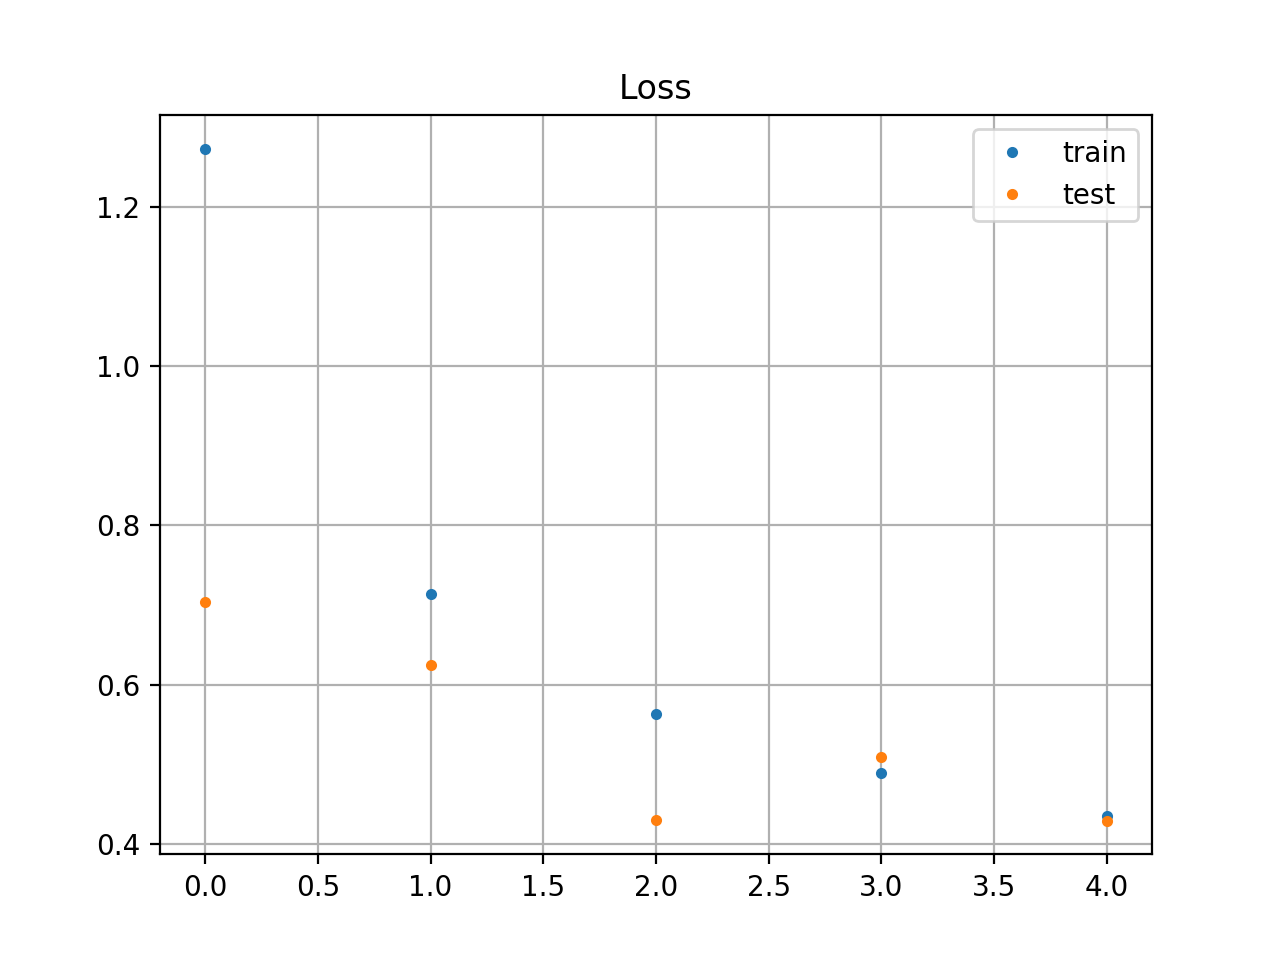

<IPython.core.display.Javascript object>


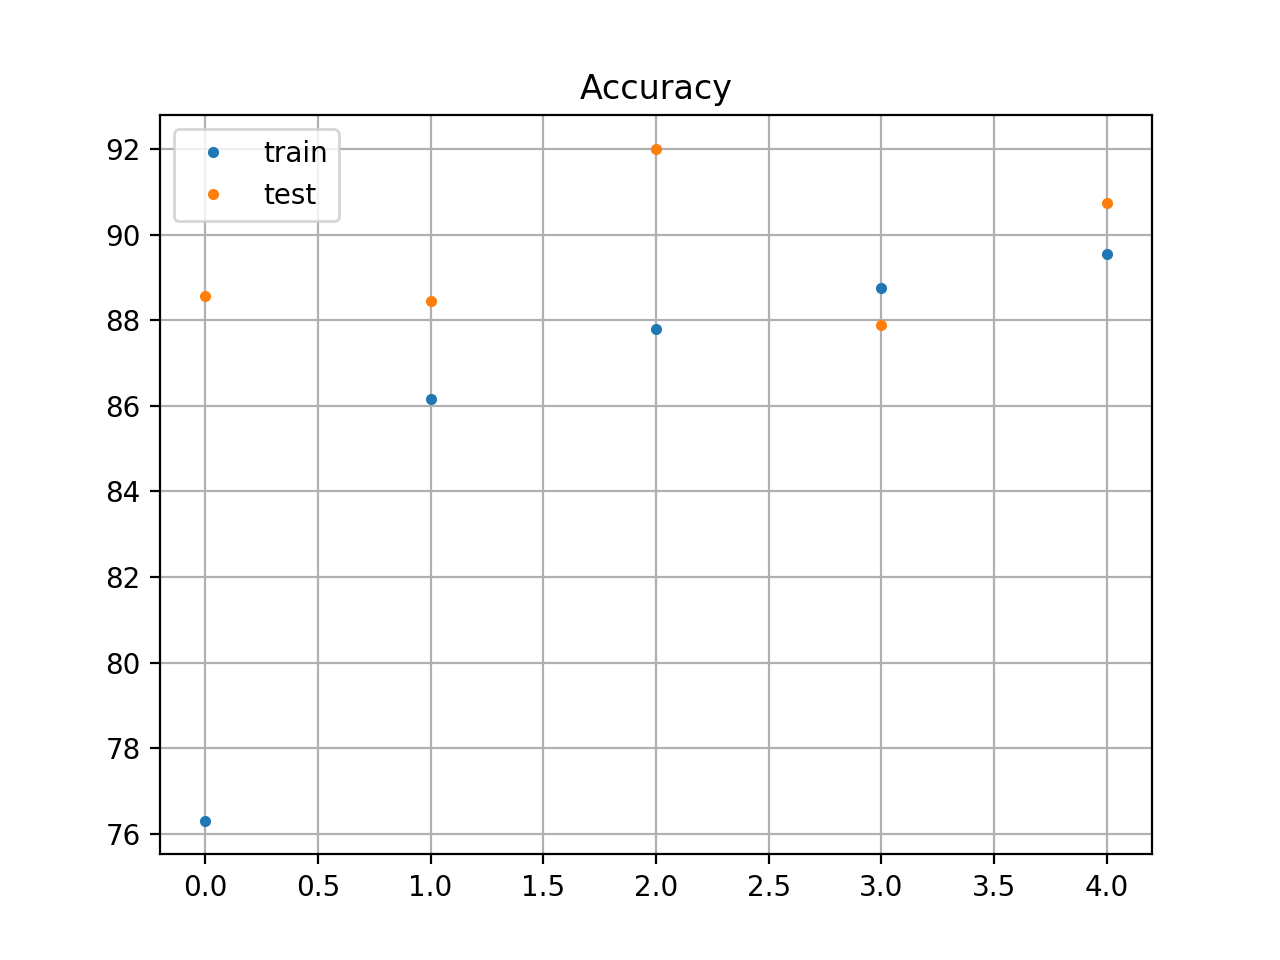

In [18]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Loss')
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ', label='train')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ', label='test')
plt.grid()
plt.legend()
plt.title('Accuracy')
plt.show()

In [19]:
### plot some FGN param movement during training

hidden_layers.4.centers
plotting neurons: [ 0 20]


<IPython.core.display.Javascript object>


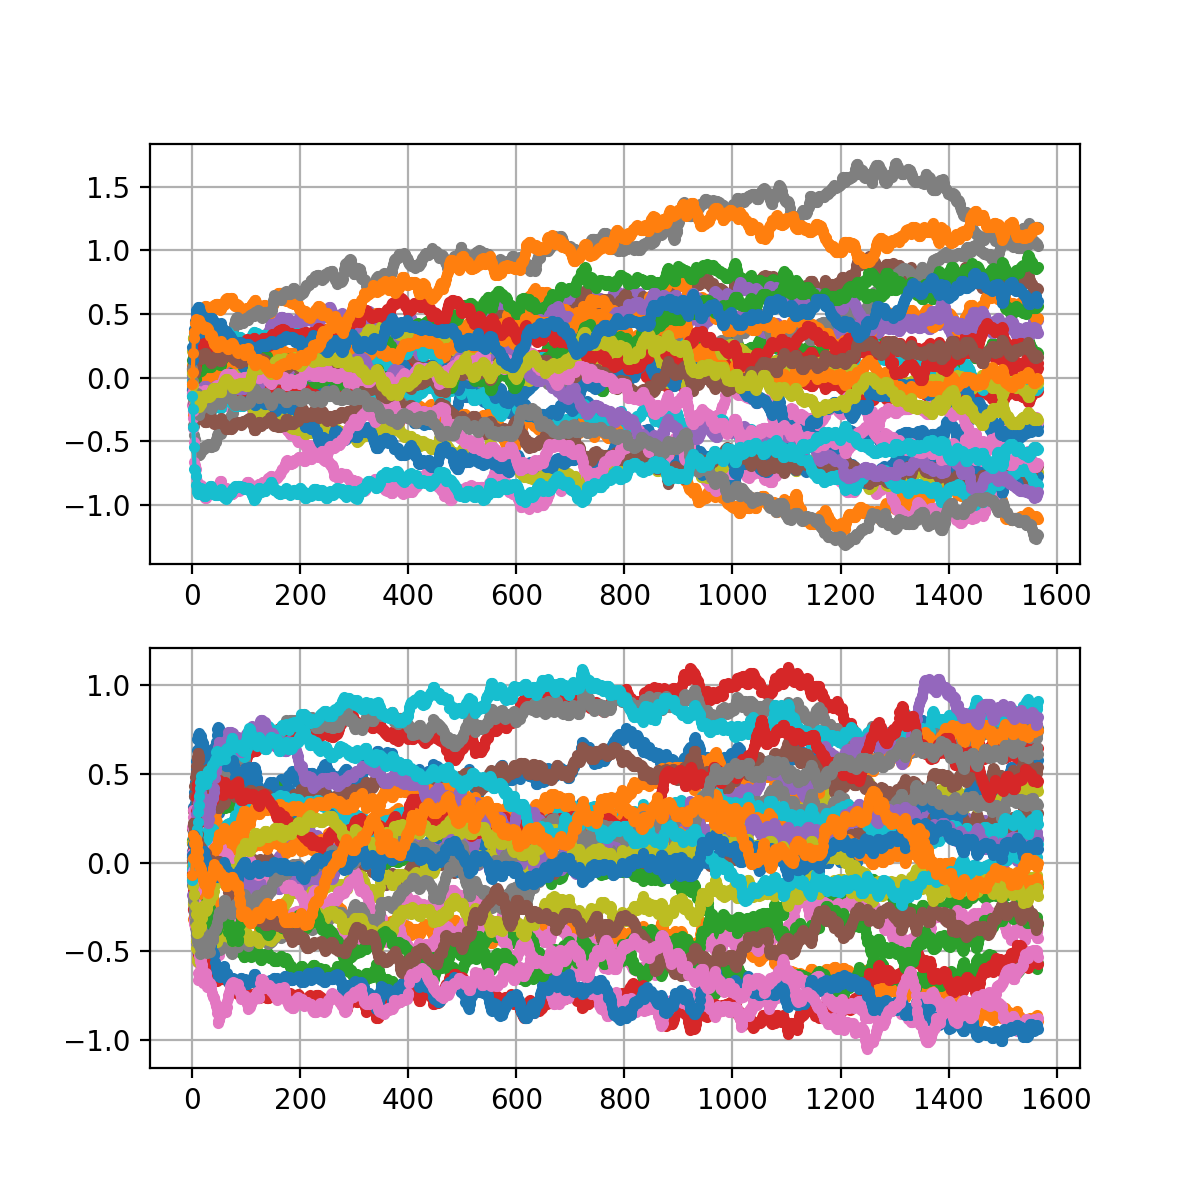

hidden_layers.1.centers
plotting neurons: [ 7 12]


<IPython.core.display.Javascript object>


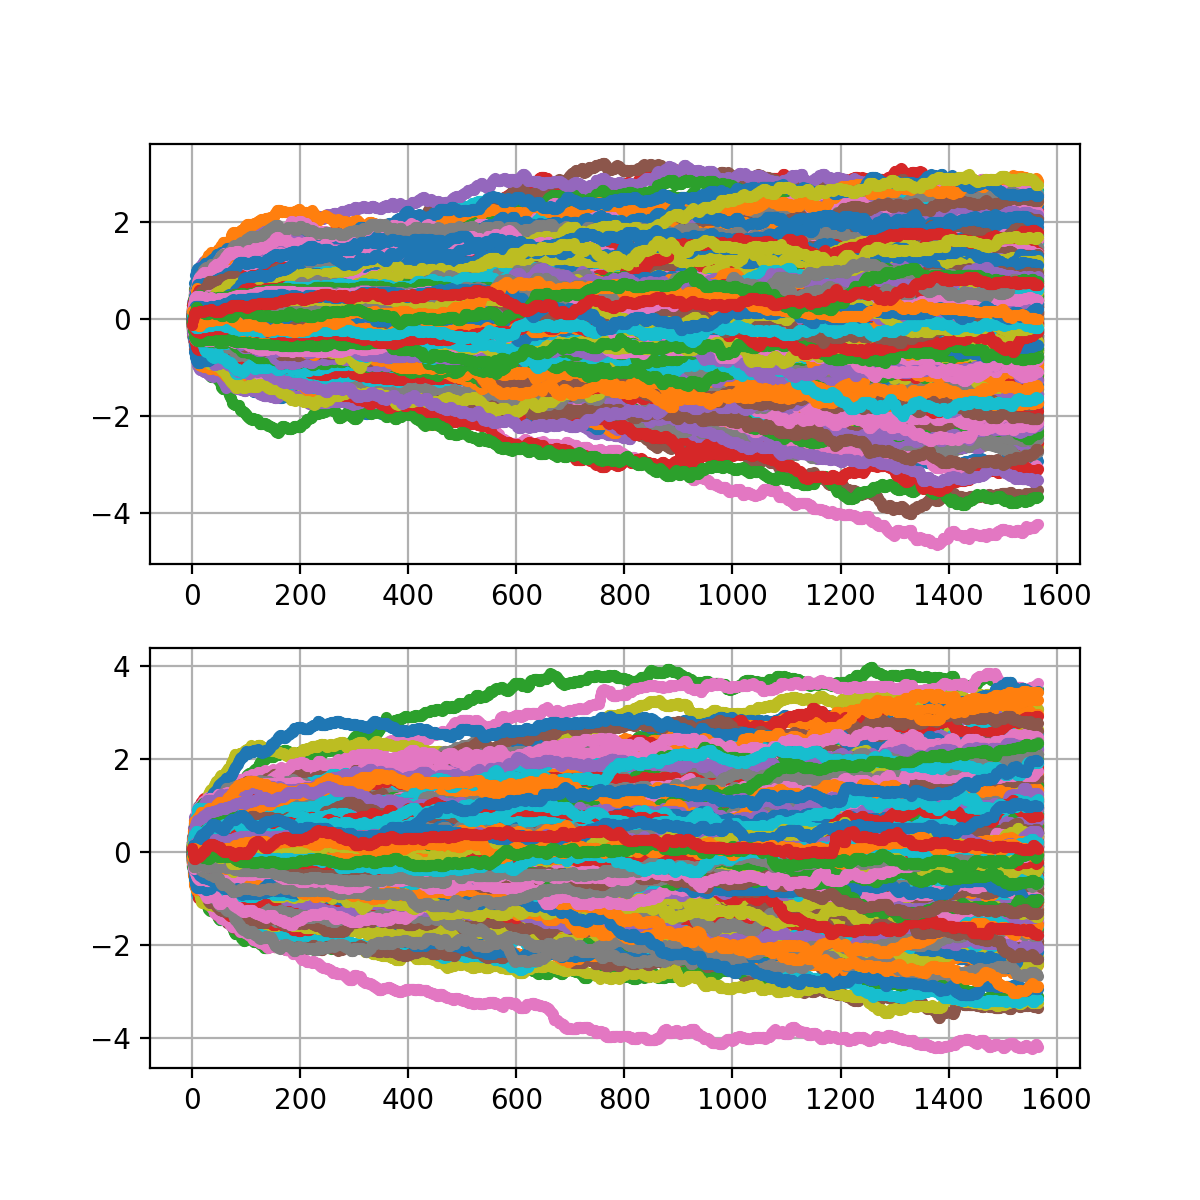

fl.centers
plotting neurons: [3 0]


<IPython.core.display.Javascript object>


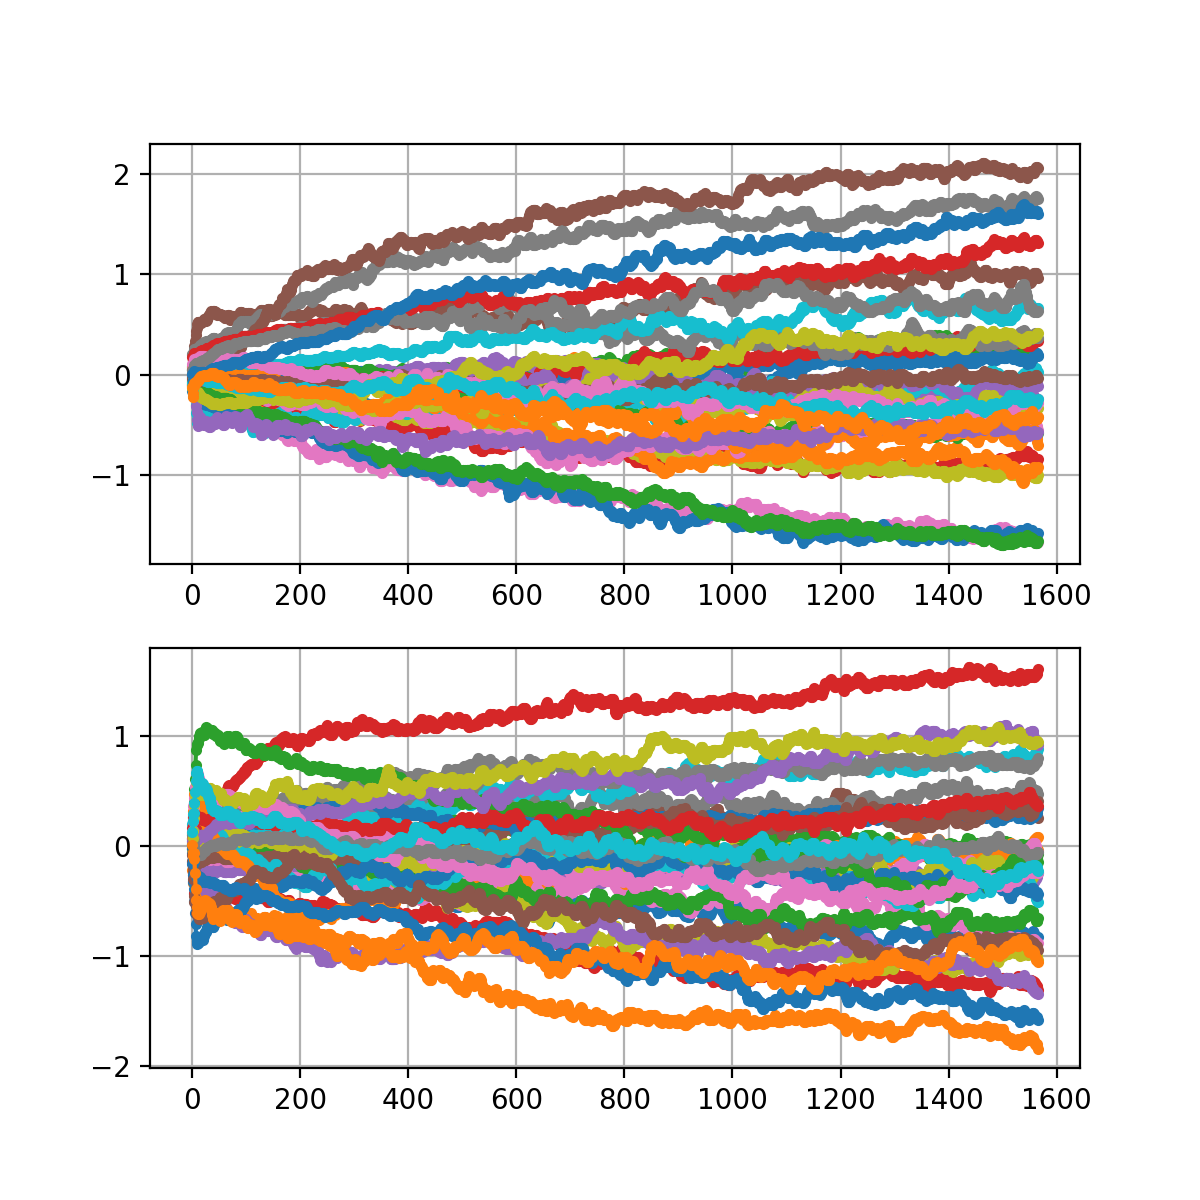

In [20]:
# plot centers history for only some hidden layer neuron
# for full FGN

for k in train_res['histories'].keys():
    if 'centers' in k:
        print(k)
        plt.figure(figsize=(6,6))
        # print(np.shape(fgn_fgn_train_res['histories'][k]))
        # choose 4random neurons in the layer to print
        neurons =  np.random.choice(range(np.shape(train_res['histories'][k])[1]),2, replace=False)
        print("plotting neurons:", neurons)
        # plt.figure(figsize=(2,2))

        for idx,n in enumerate(neurons):
            x = train_res['histories'][k][:,n,:]
            # print(np.shape(x))
            plt.subplot(2,1,idx+1)
            plt.plot(x, marker='.', linestyle='-')
            # plt.axis([-3,3, -3, 3])
            plt.grid()
        plt.show()

fl.sigmas


<IPython.core.display.Javascript object>


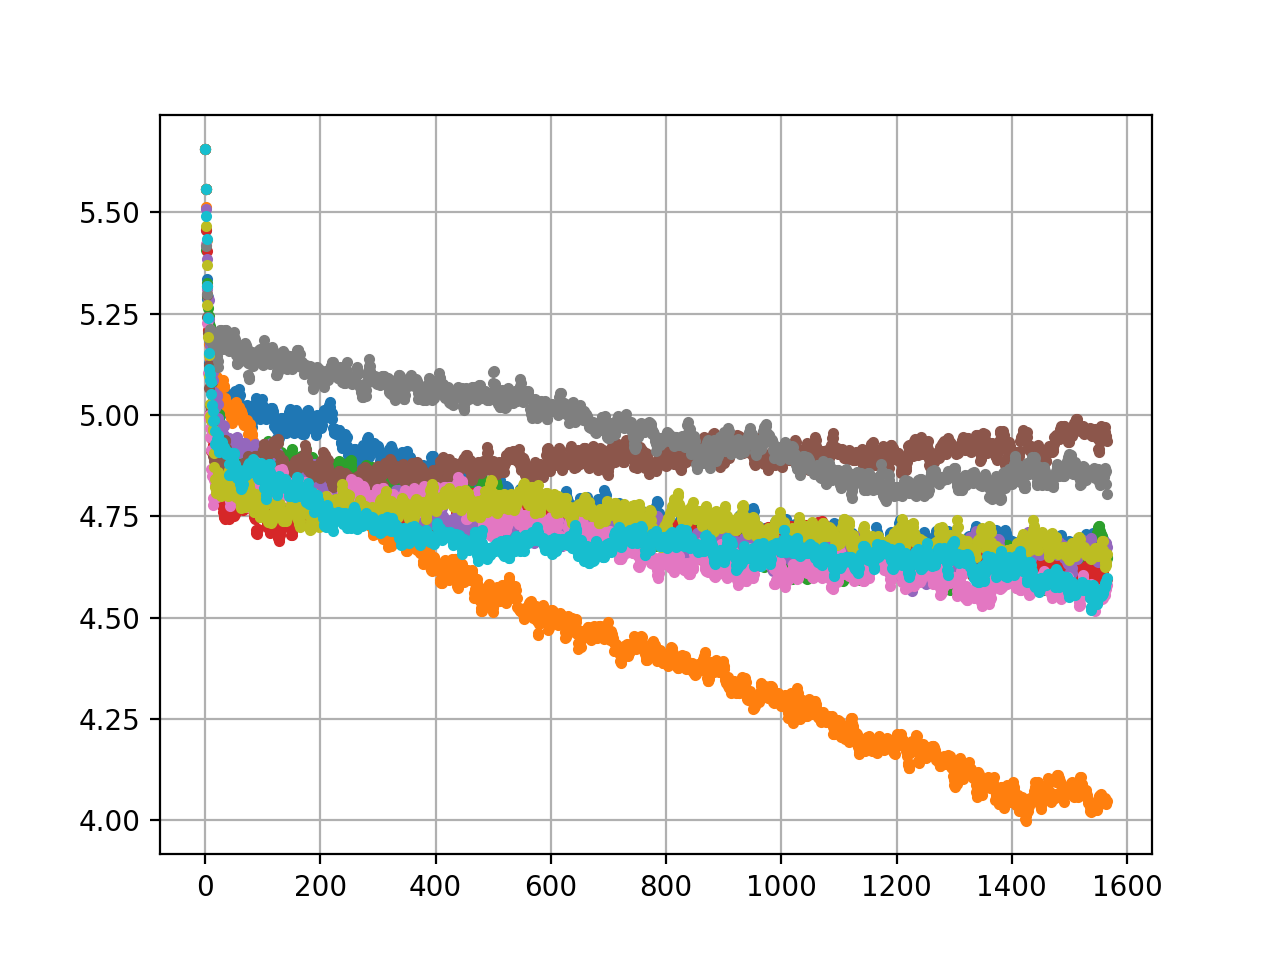

hidden_layers.4.sigmas


<IPython.core.display.Javascript object>


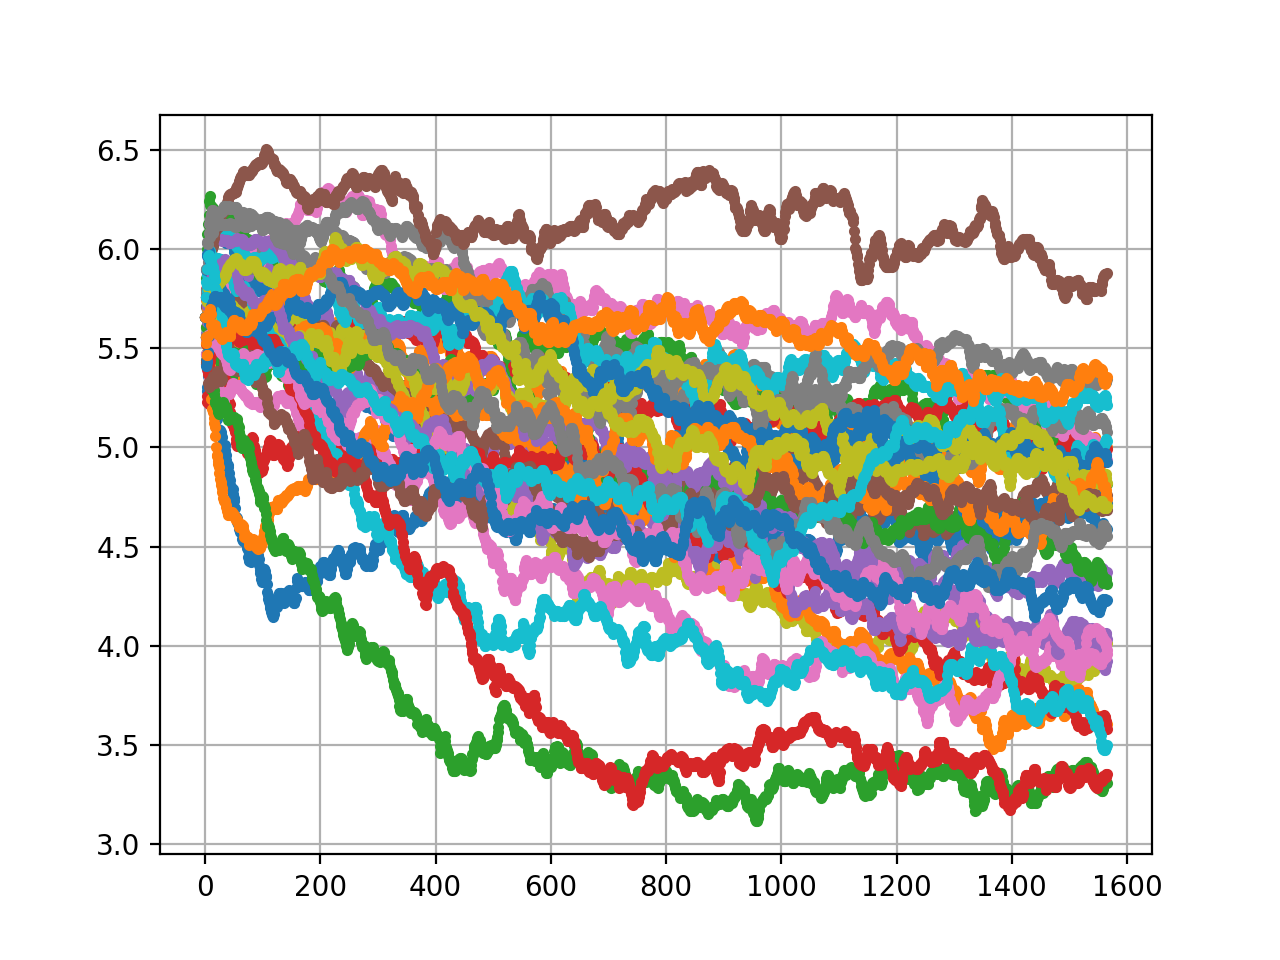

hidden_layers.1.sigmas


<IPython.core.display.Javascript object>


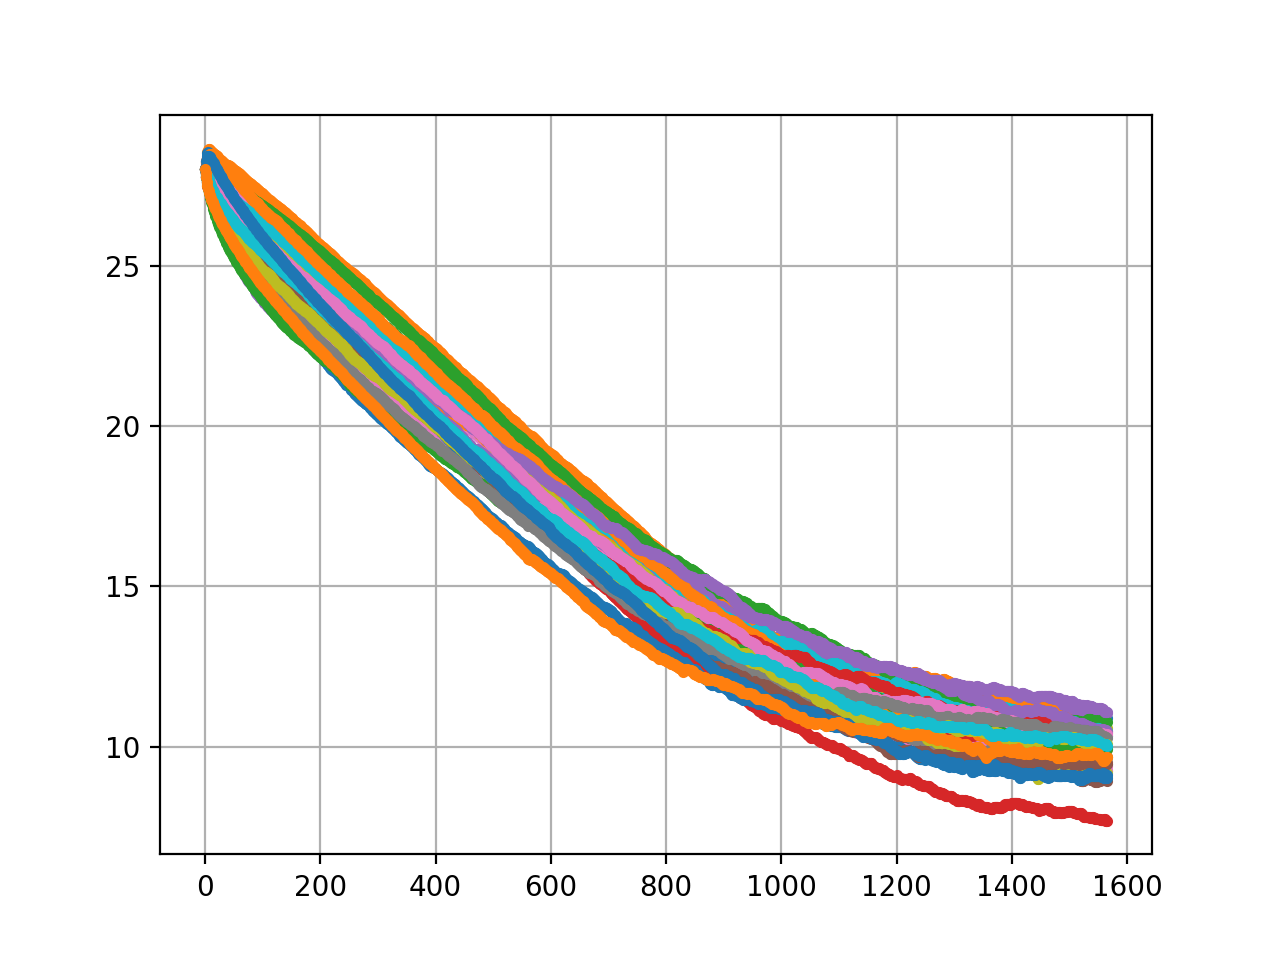

In [21]:
# check that sigma has shrunk
# plot sigma history
for k in train_res['histories'].keys():
    if 'sigmas' in k:
        print(k)
        for i in range(len(train_res['histories'][k][0])):
            plt.plot(train_res['histories'][k][:,i], marker='.', linestyle=' ')
        plt.grid()
        plt.show()

In [22]:
# save the models as dev models for future use

In [24]:
model_name = "sample_fgn_model_noisy_eval_overfitted_32_32_ord_1"
save_path = "../Experiments/sample_models/"
print("Saving trained model {} in {}".format(model_name, save_path))

# save model entirely
torch.save(model, save_path+model_name+"_full.pth")

# save model weights
torch.save(model.state_dict(), save_path+model_name+"_state_dict.pth")

# save training performance
with open(save_path+model_name+"_history.txt", "w") as text_file:
    text_file.write("Train Losses \n{}\n".format(str(train_res['train_loss_hist'])))
    text_file.write("Train Acc \n{}\n".format(str(train_res['train_acc_hist'])))
    text_file.write("Test Losses \n{}\n".format(str(train_res['test_loss_hist'])))
    text_file.write("Test Acc \n{}\n".format(str(train_res['test_acc_hist'])))

# save parameters
with open(save_path+model_name+"_parameters.txt", "w") as text_file:
    text_file.write("hidden_l_nums {}\n".format(str(hidden_l_nums)))
    text_file.write("drop_p {}\n".format(str(drop_p)))
    text_file.write("noisy_centers {}\n".format(str(noisy_centers)))
    text_file.write("batch_size {}\n".format(str(batch_size)))

Saving trained model sample_fgn_model_noisy_eval_overfitted_32_32_ord_1 in ../Experiments/sample_models/
